In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from funcs.geometry import (create_spherical_grid,
                            set_up_oblique_auroral_ring,
                            rotate_around_arb_axis,
                            calculate_surface_element_velocities)

from astropy.constants import R_sun

# dark background
plt.style.use('dark_background')


def x_params(alpha, i_rot, i_mag, latitude):
    """Calculate the parameters for the x-position of the ring.

    Parameters
    ----------
    alpha : float
        The rotational phase of the star in rad.
    i_rot : float
        The rotation inclination in rad.
    i_mag : float
        The magnetic obliquity in rad.
    latitude : float
        The pi/2 - latitude of the ring in rad.

    Returns
    -------
    A : float
        The A parameter of the ring position.
    B : float
        The B parameter of the ring position.
    C : float
        The C parameter of the ring position.
    """

    # define shorthands for various trig functions
    sa, ca = np.sin(alpha), np.cos(alpha)
    si, ci = np.sin(i_rot), np.cos(i_rot)
    st, ct = np.sin(latitude), np.cos(latitude)
    sip, cip = np.sin(i_rot + i_mag), np.cos(i_rot + i_mag)
    Ca = 1 - np.cos(alpha)

    # calculate the parameters
    A = ct * sip * (ca + si**2 * Ca) + ct * cip *ci * si * Ca
    B = cip * st  * (ca + si**2 * Ca) - sip * st * ci * si * Ca
    C = - sa * ci * st

    return A, B, C

def vx_params(alpha, i_rot, i_mag, latitude):
    """Calculate the parameters for the x-velocity of the ring.

    Parameters
    ----------
    alpha : float
        The rotational phase of the star in rad.
    i_rot : float
        The rotation inclination in rad.
    i_mag : float
        The magnetic obliquity in rad.
    latitude : float
        The pi/2 - latitude of the ring in rad.

    Returns
    -------
    X : float
        The X parameter of the ring velocity.
    Y : float
        The Y parameter of the ring velocity.
    Z : float
        The Z parameter of the ring velocity.
    """
    
    # define shorthands for various trig functions
    sa, ca = np.sin(alpha), np.cos(alpha)
    si, ci = np.sin(i_rot), np.cos(i_rot)
    st, ct = np.sin(latitude), np.cos(latitude)
    sip, cip = np.sin(i_rot + i_mag), np.cos(i_rot + i_mag)

    # calculate the parameters
    X = -sa * (sip * ct - ct * sip * si**2 - ct * cip * si * ci)
    Y = -sa * cip *st + sa * cip * st * si**2 - sa * sip * st * ci *si
    Z = -ca * ci * st

    return X, Y, Z



def v_phi(phi, X, Y, Z):
    """Calculate the x-velocity of the ring at a given phase angle phi.
    
    Parameters
    ----------
    phi : array
        The phase angles of the ring in rad. From 0 to 2 pi.
    X : float
        The X parameter of the ring velocity.
    Y : float
        The Y parameter of the ring velocity.
    Z : float
        The Z parameter of the ring velocity.

    Returns
    -------
    v : array
        The x-velocity of the ring at the given phase angles.
    """
    return Y * np.sin(phi) + Z * np.cos(phi) + X


def flux_at_x_vx(vx, x, X, Y, Z):
    """Calculate the flux of the ring at a given x position and x-velocity.
    Use the derivative of the phi(vx) function to calculate the flux, then 
    multiply by the geometrical foreshortening factor.
    
    Parameters
    ----------
    vx : array
        The x-velocity of the ring.
    x : array
        The x position of the ring.
    X : float
        The X parameter of the ring velocity.
    Y : float
        The Y parameter of the ring velocity.
    Z : float
        The Z parameter of the ring velocity.

    Returns
    -------
    flux : array
        The flux of the ring at the given positions and velocities.
    """
    foreshortening = np.cos(np.pi/2 - np.arcsin(x)) 
    flux = 1 / np.sqrt(-(vx - X)**2 + Y**2 + Z**2 + 10*np.max(np.abs(vx-X)))
    
    return flux * foreshortening



def x_phi(phi, A, B, C):
    """Calculate the x position of the ring at a given phase angle phi.
    
    Parameters
    ----------
    phi : array
        The phase angles of the ring in rad. From 0 to 2 pi.
    A : float
        The A parameter of the ring position.
    B : float
        The B parameter of the ring position.
    C : float       
        The C parameter of the ring position.
    """
    return B * np.sin(phi) + C * np.cos(phi) + A



def get_spectral_line(phi, i_rot, i_mag, latitude, alpha, bins, omega, Rstar):
    """Calculate the broadened spectral line of the infinitesimally narrow
    auroral ring.
    
    Parameters
    ----------
    phi : array
        The phase angles of the ring in rad. From 0 to 2 pi.
    i_rot : float
        The rotation inclination in rad.
    i_mag : float
        The magnetic obliquity in rad.
    latitude : float
        The latitude of the ring in rad.
    alpha : float
        The rotational phase of the star in rad.
    bins : int
        The number of velocity bins to use for the spectral line.
    omega : float
        The rotation rate of the star in rad / day.
    Rstar : float
        The radius of the star in solar radii.

    Returns
    -------
    flux : array
        The flux of the spectral line.
    """

    # get the parameters for the positions
    A, B, C = x_params(alpha, i_rot=i_rot, i_mag=i_mag, latitude=np.pi/2 - latitude)

    # get the parameters for the velocities
    X, Y, Z = vx_params(alpha, i_rot=i_rot, i_mag=i_mag, latitude=np.pi/2 - latitude)

    # get the velocities and positions
    v = v_phi(phi, X, Y, Z)
    x = x_phi(phi, A, B, C)

    # get the flux
    flux = flux_at_x_vx(v, x, X, Y, Z)

    # mask the flux
    flux[x<0] = 0

    # rebin flux and v

    # first make a pandas dataframe
    df = pd.DataFrame({'phi': phi, 'v': v, 'flux': flux})

    # sort by v
    df = df.sort_values(by=['v'], ascending=True)

    # convert to stellar radii / s and then to km/s
    df.v = df.v * omega / 86400 * Rstar * 695700. 

    # bin in v and sum the flux
    df_v = df.groupby(pd.cut(df['v'], bins=bins)).sum()

    # get the flux at the midpoints
    flux = df_v['flux'].values / df_v["flux"].max()

    return flux


def numerical_spectral_line(alpha, x, y, z, z_rot, omega, Rstar, bins, dalpha=.1 * np.pi/180):
    """Calculate the broadened spectral line of the ring defined
    by x, y, z.

    Parameters
    ----------
    alpha : float
        The rotational phase of the star in rad.
    x : array
        The x positions of the ring in stellar radii.
    y : array
        The y positions of the ring in stellar radii.
    z : array
        The z positions of the ring in stellar radii.
    z_rot : float
        The rotational axis of the star in rad.
    omega : float
        The rotation rate of the star in rad / day.
    Rstar : float
        The radius of the star in solar radii.
    bins : array
        The velocity bins to use for the spectral line.
    dalpha : float
        The step size in alpha to use for velocity calculation.

    Returns
    -------
    flux : array
        The flux of the spectral line.
    """
    # rotate the ring
    xr, _, _ = rotate_around_arb_axis(alpha, np.array([x, y, z]), z_rot)

    # calculate the surface element velocities
    dxr_visible = calculate_surface_element_velocities(alpha, dalpha, x, y, z, z_rot, omega, Rstar)

    # define the visible part of the ring
    q = xr > 0

    # bin the flux
    flux, bins = np.histogram(dxr_visible, bins=bins, weights=np.cos(np.pi/2 - np.arcsin(xr[q])))

    # normalize the flux
    flux = flux / np.max(flux)

    return flux



In [ ]:
# define an AuroralRing class

class AuroralRing:
    """A class to represent an auroral ring on a star.

    Attributes
    ----------
    i_rot : float
        The rotation inclination in rad.
    i_mag : float
        The magnetic obliquity in rad.
    latitude : float
        The mid-latitude of the ring in rad.
    width : float
        The width of the ring in rad.
    Rstar : float
        The radius of the star in solar radii.
    P_rot : float
        The rotation period of the star in days.
    phi : array
        The phase angles of the ring in rad. From 0 to 2 pi of size N.
    omega : float
        The rotation rate of the star in rad / day.
    v_bins : array
        The velocity bins to use for the spectral line.
    lat_min : float
        The minimum latitude of the ring in rad.
    lat_max : float
        The maximum latitude of the ring in rad.
    v_mids : array
        The midpoints of the velocity bins.
    """

    # init function takes the parameters of the ring and sets up the phi array
    def __init__(self, i_rot, i_mag, latitude, width, Rstar, P_rot, N=1000):
        """Initialize the AuroralRing class.

        Parameters
        ----------
        i_rot : float
            The rotation inclination in rad.
        i_mag : float
            The magnetic obliquity in rad.
        latitude : float
            The mid-latitude of the ring in rad.
        width : float
            The width of the ring in rad.
        Rstar : float
            The radius of the star in solar radii.
        P_rot : float
            The rotation period of the star in days.
        N : int 
            The number of phase angles to use for the ring.
            The same is used for the velocity bins.
        """
        self.i_rot = i_rot
        self.i_mag = i_mag
        self.latitude = latitude
        self.width = width
        self.Rstar = Rstar
        self.P_rot = P_rot

        # set up the phi array
        self.phi = np.linspace(0, 2*np.pi, N)

        # calculate omega
        self.omega = 2 * np.pi / self.P_rot

        # set up velocity bins based on the highest possible velocity
        vmax = 2 * np.pi * self.Rstar * 695700. / self.P_rot / 86400. # km/s
        self.v_bins = np.linspace(-vmax, vmax, N)

        # calculate max and min latitude of the ring using width
        self.lat_min = latitude - width/2
        self.lat_max = latitude + width/2

        # define binmids for the velocity bins
        self.v_mids = (self.bins[1:] + self.bins[:-1]) / 2

/tmp/ipykernel_370195/3584952862.py:219: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_v = df.groupby(pd.cut(df['v'], bins=bins)).sum()
/tmp/ipykernel_370195/3584952862.py:219: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_v = df.groupby(pd.cut(df['v'], bins=bins)).sum()
/tmp/ipykernel_370195/3584952862.py:219: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_v = df.groupby(pd.cut(df['v'], bins=bins)).sum()


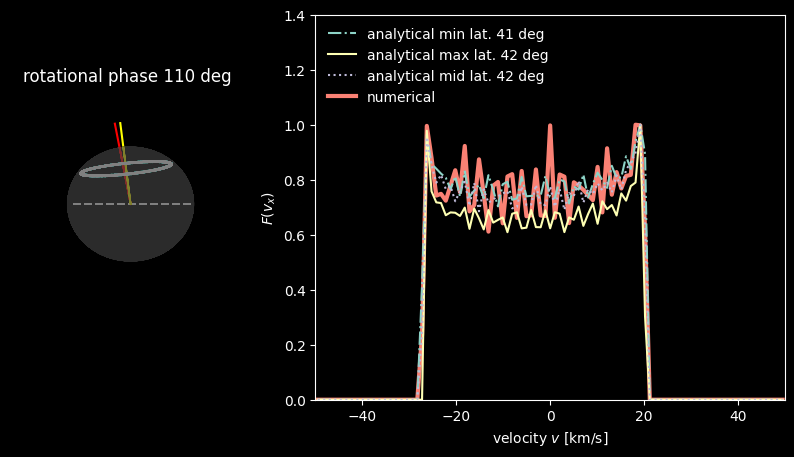

In [5]:
# --- SET UP the numerical solution

THETA, PHI = create_spherical_grid(int(1e5))
# input parameters

# rotation period in days
P_rot = 0.5 * np.pi

# stellar radius in solar radii
Rstar = 1.

# upper latitude of ring around magnetic axis in radians
PHI_max = 42 * np.pi/180

# lower latitude of ring around magnetic axis in radians
PHI_min = 41 * np.pi/180

# lower latitude must be smaller than upper latitude
assert PHI_min < PHI_max

# convert dxr_visible from km/s to nm using speed of light
# and wavelength of the line
c = 299792.458 # km/s
wavelength = 3825.4 # AA Ca II H line
bins = np.linspace(-1,1,200)

#  SET UP the analytical solution

phi = np.linspace(0, 2*np.pi, 1500)

# inclination of rotation axis in radians with the right convention
i_rot = np.pi/2 - 80 * np.pi/180

# inclination of magnetic axis in radians relative to rotation axis
i_mag = 10 * np.pi/180

# latitude of the ring in radians
latitude = PHI_min#(PHI_max + PHI_min) / 2

# angular velocity in rad/d
omega = 2 * np.pi / P_rot

# phase
alpha = 110 * np.pi/180

# velocity bins
bins = np.linspace(-50,50,100)
binmids = (bins[1:] + bins[:-1])/2


# NUMERICAL solution ------

(x, y, z), z_rot, z_rot_mag = set_up_oblique_auroral_ring(THETA, PHI, PHI_max, PHI_min, i_rot, i_mag)

xr, yr, zr = rotate_around_arb_axis(alpha, np.array([x, y, z]), z_rot)

numerical_line = numerical_spectral_line(alpha, x, y, z, z_rot, omega, Rstar, bins, dalpha=.1 * np.pi/180)

# -------------------------




# FIGURE SETUP ------

# set up a figure with six panels in a 3x2 grid, the first panel is in 3d projection
fig = plt.figure(figsize=(10, 5))
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1, 2])

ax = fig.add_subplot(spec[0, 0], projection='3d')
ax.set_axis_off()
ax1 = fig.add_subplot(spec[0, 1])

# --------------------



# THE SPHERE ---------

ax.scatter(np.sin(THETA)*np.cos(PHI),
              np.sin(THETA)*np.sin(PHI),
              np.cos(THETA), c='grey', alpha=0.01)

# plot the x axis as a dashed line
ax.plot([-1, 1], [0, 0], [0, 0], c='w', ls='--')

z_mag_alpha = rotate_around_arb_axis(alpha, z_rot_mag, z_rot)

# plot z_rot
ax.plot([0, 1.5 *z_rot[0]], [0, 1.5 *z_rot[1]], [0,1.5 * z_rot[2]], c='r')


# plot z_rot_mag
ax.plot([0, z_mag_alpha[0]], [0, z_mag_alpha[1]], [0, z_mag_alpha[2]], c='yellow')

# THE RING ----------

# plot the rotated blue points
ax.scatter(xr, yr, zr, alpha=1, s=1)

# --------------------



# LAYOUT -------------

# set figure limits to -1.5 to 1.5 on eacha xis
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_zlim(-1., 1.)

# label axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# rotate the figure such that x-axis point towards me
ax.view_init(0, 90)

# legend
ax.set_title(f'rotational phase {alpha*180/np.pi:.0f} deg')

# let axes disappear
ax.set_axis_off()

# --------------------




# ANALYTICAL solution

for linestyle, label, latitude in zip(
                    ['-.', '-', ':'],
                    ["min lat.", "max lat.", "mid lat."], 
                    [PHI_min, PHI_max, (PHI_max + PHI_min)/2]):
    
    analytical_line = get_spectral_line(phi, i_rot, i_mag, latitude, alpha, bins, omega, Rstar)
            


    ax1.plot(binmids, analytical_line, label=f"analytical {label} {latitude/np.pi*180:.0f} deg", linestyle=linestyle)



ax1.plot(binmids, numerical_line, zorder=-10, linestyle="-", label="numerical", linewidth=3)
ax1.set_xlabel(r'velocity $v$ [km/s]')
ax1.set_ylabel(r'$F(v_x)$')
ax1.set_xlim(-50, 50)
ax1.set_ylim(0,1.4)
ax1.legend(frameon=False, loc='upper left')





In [3]:
phi = np.linspace(0, 2*np.pi, 150)

# inclination of rotation axis in radians with the right convention
i_rot = np.pi/2 - 80 * np.pi/180

# inclination of magnetic axis in radians relative to rotation axis
i_mag = 70 * np.pi/180

# latitude of the ring in radians
latitude = 60 * np.pi/180

# alpha=np.pi/3

# go through phi_bound

# fig, axes = plt.subplots(1,1,figsize=(10, 10))
# axes = axes.flatten()

fluxes = []
vs = []

for alpha in np.linspace(0, 2*np.pi,100):
    res = get_spectral_line(phi, i_rot, i_mag, latitude, alpha)
    print(alpha)
    phi_bounds, phi_bounds_v, signum, v_bounds_phi, v_bounds, flux, fluxmask, mask, v, phi, A, B, C = res

    fluxes.append((flux*fluxmask)[mask])
    vs.append(v[mask])

# make a dataframe from vs and fluxes
df = pd.DataFrame({'v': np.concatenate(vs), 'flux': np.concatenate(fluxes)})

# bin in v space and sum fluxes
df_binned = df.groupby(pd.cut(df.v, bins=100)).sum()

# plot
df_binned.index = pd.IntervalIndex(df_binned.index).mid

plt.plot(df_binned.index.values,  df_binned.flux.values)
plt.ylim(0,)

TypeError: get_spectral_line() missing 3 required positional arguments: 'bins', 'omega', and 'Rstar'

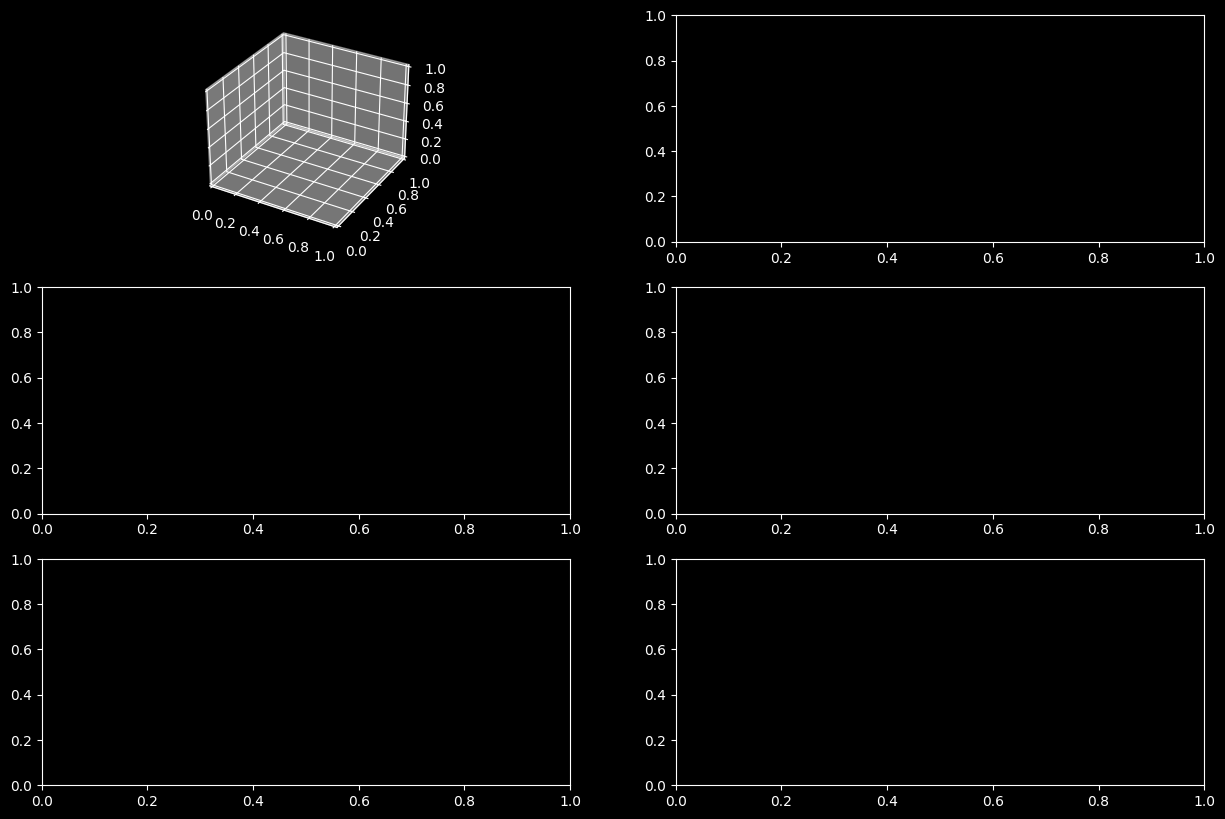

In [ ]:
# set up a figure with six panels in a 3x2 grid, the first panel is in 3d projection
fig, axes = plt.subplots(3,2,figsize=(15, 10))
axes = axes.flatten()

# add the 3d projection to the top panel
ax = fig.add_subplot(321, projection='3d')

axes[0].set_axis_off()

ax2 = ax4

ax3 = ax1

## Archive

In [ ]:

v = np.linspace(-5, 5, 200)

phi1, phi2 = phi_v(v, X, Y, Z)

plt.plot(v, phi1, linewidth=6, label=r'$\phi_1(v)$')
plt.plot(v, phi2, linewidth=4, label=r'$\phi_2(v)$')


phi = np.linspace(0, 2*np.pi, 100)

v1 = v_phi(phi, X, Y, Z)

plt.plot(v1, phi, linestyle='--', c="r", label=r'$v(\phi)$')

#fill between phi 5 and 5.5 horizontal
plt.fill_between(v, 5, 6, color='orange', alpha=0.4)
plt.fill_between(v, 0, 1.7, color='orange', alpha=0.4, label="integration bounds")


plt.xlabel(r'$v$')
plt.ylabel(r'$\phi$')
plt.legend(frameon=False, loc=(.5,.4), fontsize=14)
# plt.xlim(-3, 5)
plt.ylim(0, 2*np.pi);

NameError: name 'X' is not defined

In [ ]:
def get_v_bounds(X, Y, Z):

    phi_where_v_turns = [np.arctan(Y/Z)]

    if phi_where_v_turns[0] < np.pi:
        phi_where_v_turns.append(np.arctan(Y/Z) + np.pi)
    elif phi_where_v_turns[0] > np.pi:
        phi_where_v_turns.append(np.arctan(Y/Z) - np.pi)

    for i in range(2):
        if phi_where_v_turns[i] < 0:
            print("phi < 0")
            phi_where_v_turns[i] = phi_where_v_turns[i] + 2 * np.pi
        elif phi_where_v_turns[i] > 2 * np.pi:
            print("phi > 2pi")
            phi_where_v_turns[i] = phi_where_v_turns[i] - 2 * np.pi

    zero_v = v_phi(phi_where_v_turns, X, Y, Z)    

    signum = np.sign( - np.sin(phi_where_v_turns) * Y - np.cos(phi_where_v_turns) * Z)
    
    return phi_where_v_turns, zero_v, signum

def get_phi_bounds(phi, A, B, C, X, Y, Z):

    a, b = B/A, C/A

    bounds = []
    for n in range(-2, 3):

        _ = a**2 + b**2 - 1 
        
        if _ > 0:
            b1 = 2 * (np.arctan((a - np.sqrt(_)) / (b - 1)) + n * np.pi)
            if (b1 > 0) & (b1 < 2 * np.pi):
                bounds.append(b1)
            b2 = 2 * (np.arctan((a + np.sqrt(a**2 + b**2 - 1)) / (b - 1)) + n * np.pi)
            if (b2 > 0) & (b2 < 2 * np.pi):
                bounds.append(b2)

    # derivative of the function gets us which side of the bound to include
    bounds = np.sort(np.array(bounds))

    # get the derivative dx/dphi
    dx_dphi_at_bounds = np.sign(dx_dphi(bounds, B, C))

    # print(bounds, dx_dphi_at_bounds)

    def bounds_mask(phi):

        default = (phi < 2 * np.pi) & (phi > 0)
        mark = 1 # we start inclusive 

        for bound, dx_dphi_at_bound in zip(bounds, dx_dphi_at_bounds):

            if dx_dphi_at_bound == 1:

                if mark == 1:
                    # print("1")
                    default = default & (phi >bound)
                    mark = 1
                    # print("We are already inclusive, but the slope is positive, "
                    #       "so we must be at the beginning of the full interval")

                elif mark == 0:
                    # print("2")
                    default = default | (phi > bound)
                    mark = 1
                    # print("The slope has been negative, changes to positive, "
                    #       "so we must be at the beginning of an included interval")

            elif dx_dphi_at_bound == -1:

                if mark == 1:
                    # print("3")
                    default = default & (phi < bound)
                    mark = 0
                    # print("We are already inclusive, but the slope is negative, "
                    #       "so we must be at the end of the included interval.")

                elif mark == 0:
                    raise ValueError('negative slope although we already have a negative slope')

        return default
    
    bounds_v = v_phi(bounds, X, Y, Z)

    return bounds, bounds_v, dx_dphi_at_bounds, bounds_mask(phi)


def phi_v(v, X, Y, Z):
    n, m = 1, 0
    phi1 = 2 * (np.arctan((Y - np.sqrt(-v**2 + 2 * v * X - X**2 + Y**2 + Z**2)) / (v - X + Z) ) + n * np.pi)
    phi2 = 2 * (np.arctan((Y + np.sqrt(-v**2 + 2 * v * X - X**2 + Y**2 + Z**2)) / (v - X + Z) ) + m * np.pi)

    return phi1, phi2



def dx_dphi(phi, B, C):
    return B * np.cos(phi) - C * np.sin(phi)

8052.083333333333

In [ ]:
24*3600

86400